In [1]:
# sources: https://docs.api.lens.org/request-scholar.html; https://docs.api.lens.org/examples-scholar.html#get-scholarly-works-using-multiple-pmid; https://docs.api.lens.org/samples-scholar.html#python

## 1. Open and merge the pubmedIDs

In [ ]:
## 2.1. Open and merge the pubmedIDs# sources: https://docs.api.lens.org/request-scholar.html; https://docs.api.lens.org/examples-scholar.html#get-scholarly-works-using-multiple-pmid; https://docs.api.lens.org/samples-scholar.html#python

In [7]:
#df.loc[df.pubMed != 'none', 'pubMed'] = 'available'
#df.loc[df.pubMed != 'none', 'origins'] = 'available'
#df.to_csv('C:/Users/pauld/Documents/GitHub/Pilot study/Cleaned full data_merged_categories.csv',index=False)

In [3]:
# inspecting whether organisms still need to be standardized
list(set(df['organism'])) # these seems to be 

['Pyrococcus furiosus COM1',
 'Thermotoga maritima MSB8',
 'Takifugu rubripes',
 'Takifugu rubripes rubripes',
 'Pyrococcus furiosus DSM 3638',
 'Photobacterium sp. SKA34',
 'Thermotoga maritima',
 'Tetraodon nigroviridis',
 'Pyrococcus furiosus']

In [4]:
# clean data so that takifugu rubripes is standardized (not sure why there are a few sequences that have rubripes twice in their name)
df = df.replace({'organism' : { 'Takifugu rubripes rubripes' : 'Takifugu rubripes', 'Pyrococcus furiosus COM1' : 'Pyrococcus furiosus', 'Thermotoga maritima MSB8' : 'Thermotoga maritima', 'Pyrococcus furiosus DSM 3638':'Pyrococcus furiosus' }})

In [5]:
# inspect the data at first: how many squences are there
df[(df['organism'] != 'Takifugu rubripes') & (df['pubMed'] != 'none')]

,AN,pubMed,origins,pub. date,organism
96,AF255623,12024264,none,2003,Photobacterium sp. SKA34
212,PYWILES,7708661,none,1995,Pyrococcus furiosus
216,AF102769,9973343,none,2016,Pyrococcus furiosus
217,AF101433,9973343,none,2016,Pyrococcus furiosus
218,AF101432,9973343,none,2016,Pyrococcus furiosus
...,...,...,...,...,...
748643,X75437,7859734,none,1995,Thermotoga maritima
748644,X74302,8404889,none,1993,Thermotoga maritima
748645,X74163,8277941,none,2016,Thermotoga maritima
748647,Y09510,9044261,none,2005,Thermotoga maritima


In [7]:
df[df['origins'] != 'none']

,AN,pubMed,origins,pub. date,organism
847,CP023154,none,Italy,2019,Pyrococcus furiosus
1426,KM892551,25566211,Italy,2015,Pyrococcus furiosus
1528,AB385663,18582469,Japan,2011,Takifugu rubripes
1529,AB385664,18582469,Japan,2011,Takifugu rubripes
1530,AB385665,18582469,Japan,2011,Takifugu rubripes
...,...,...,...,...,...
746710,HM138204,20810728,China,2010,Tetraodon nigroviridis
746858,FJ792639,none,Thailand,2009,Tetraodon nigroviridis
747736,CP011108,29959252,USA,2020,Thermotoga maritima
747737,CP010967,26021931,USA,2020,Thermotoga maritima


In [10]:
df['pub']

0         Photobacterium sp. SKA34
1         Photobacterium sp. SKA34
2         Photobacterium sp. SKA34
3         Photobacterium sp. SKA34
4         Photobacterium sp. SKA34
                    ...           
748867         Thermotoga maritima
748868         Thermotoga maritima
748869         Thermotoga maritima
748870         Thermotoga maritima
748871         Thermotoga maritima
Name: organism, Length: 748872, dtype: object

In [13]:
len(set(df['pubMed'][df['pubMed'] != 'none']))

544

In [114]:
df_vis = df.copy()
df_vis.loc[df.pubMed != 'none', 'pubMed'] = 'available'

<AxesSubplot:xlabel='organism', ylabel='Count'>

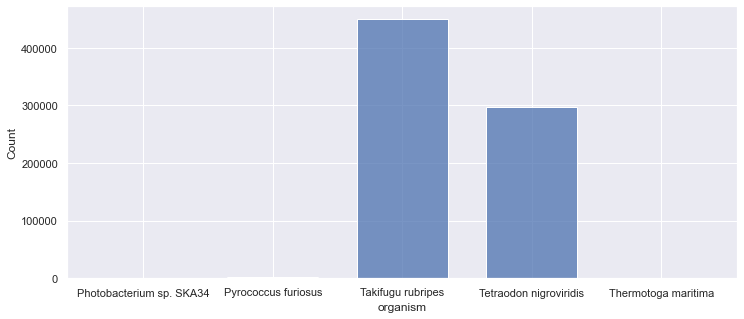

In [13]:
# count organisms
sns.histplot(df, x="organism", shrink=.7)

In [ ]:
# I could substract from the mean to ake the differences clearer

<AxesSubplot:xlabel='organism', ylabel='Probability'>

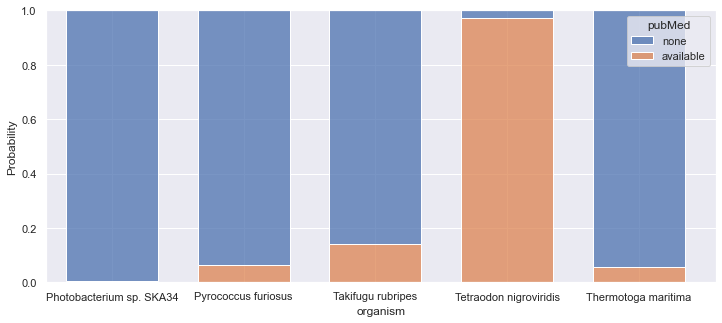

In [12]:
# plot availabililty of pubMed, origin

df_vis = df.copy()
df_vis.loc[df.pubMed != 'none', 'pubMed'] = 'available'

#df.loc[df.pubMed != 'none', 'origins'] = 'available'

sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(12,5)})

sns.histplot(df_vis, x="organism", hue="pubMed", stat="probability", multiple="fill", shrink=.7)

<AxesSubplot:xlabel='organism', ylabel='Probability'>

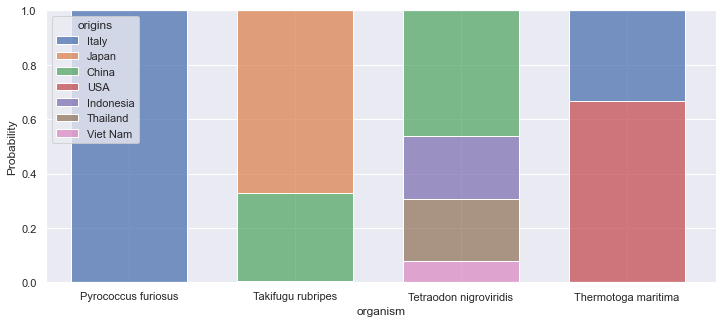

In [137]:
## Origins --> but these are overall only 222, so there is very very little country of origin info
#df_vis.loc[df.origins != 'none', 'origins'] = 'available' --> this results in only 'none' pretty much
sns.histplot(df_vis[df_vis['origins'] != 'none'], x="organism", hue="origins", stat="probability", multiple="fill", shrink=.7)

In [ ]:
# but also, scientists may be less likely to report on ABNJ? 

In [14]:
# make list of unique pubmed_ids:  
pubmed_ids_fs = list(set(df['pubMed'][df['pubMed'] != 'none']))
len(pubmed_ids_fs)



544

## 2. Download and export the scholarly raw data based on the pubmedIDs

In [19]:
# turn into json so it is readable for the iterator
s = json.dumps(pubmed_ids_fs)

#### scrape the scholarly data using the pubmedID# if doing more than 1000, I need cursor-based pagination
data = []
start_time = time.time()


url = 'https://api.lens.org/scholarly/search'

data_string = '''{
    "query": {
        "terms": {
        "pmid": %s 
                }
            },
    "size": 600
        }''' % s
headers = {'Authorization': 'IjpxxGZZQcGCQxBzAx5VDqPqHXhQjAqSkdnAYHQCRAkfkAlVDjCI', 'Content-Type': 'application/json'}
response = requests.post(url, data=data_string, headers=headers)
if response.status_code != requests.codes.ok:
    print(response.status_code)
else:
    print(response.json)
data.append(response.json())


print("--- %s seconds ---" % (time.time() - start_time))


# save it
with open(r'C:\Users\pauld\Documents\GitHub\Pilot study\Raw data\full-data_scholarly-lens.json', 'w') as f:
    json.dump(data, f)

<bound method Response.json of <Response [200]>>
--- 3.147932529449463 seconds ---


pp = pprint.PrettyPrinter()
pp.pprint(data)

## 3. Export the network data: Publications - Patents

In [50]:
# open the raw publication data again so that I can edit it
#with open(r'..\Raw data\full-data_scholarly-lens.json') as json_string:
#    data = json.load(json_string)
    
    

In [55]:
#data[0]['data'][0]['lens_id']

'000-088-774-471-797'

In [79]:
# publications
patent_ids = []
publications_ids = []
pubmed_ids = []

for i in data: 
    for k, v in i.items(): 
        if k == 'data': 
            for publication in v: 
                for key, value in publication.items(): 
                    if key == 'patent_citations': 
                        for ii in value: 
                            for keyss, valuess in ii.items(): 
                                patent_ids.append(valuess)
                                publications_ids.append(publication['lens_id'])
                                for e in publication['external_ids']:
                                    if 'pmid' in e.values():
                                        pubmed_ids.append(e['value'])
                                        
                        
                        
                        
                        
                        #for e in publication['external_ids']:
                        #    for keys, values in e.items():
                        #        if values == 'pmid':
                        #            for ii in value: 
                        #                for keyss, valuess in ii.items(): 
                        #                    patent_ids.append(valuess)
                        #                    pubmed_ids.append(e['value'])
                                    

In [ ]:
# it is strange how every single publication appears to have a pmid

In [88]:
# merge the lists into dict and to pandas                                    
dictdata = {'publication_ids': publications_ids, 'patentID': patent_ids, 'pubmed_IDs': pubmed_ids} # maybe I have to write it as dict instead of dictdata? 
df_edge = pd.DataFrame(dictdata)
            
## export the data files
df_edge.to_csv('../Network data/pub_patent_edges.csv',index=False)


In [24]:
# look at frequenies
counter=collections.Counter(pubmed_ids)
print('publications most frequently cited in patents')
counter.most_common()



publications most frequently cited in patents


[('16381832', 327),
 ('10360571', 68),
 ('14765194', 60),
 ('9560249', 53),
 ('14623098', 46),
 ('9680336', 41),
 ('9293008', 40),
 ('9195939', 36),
 ('8522516', 32),
 ('8441634', 32),
 ('15590700', 26),
 ('10542158', 26),
 ('12893874', 20),
 ('8828221', 20),
 ('10430560', 20),
 ('11782527', 19),
 ('8872459', 18),
 ('8798600', 18),
 ('15976025', 18),
 ('8277941', 17),
 ('9006052', 17),
 ('12813049', 17),
 ('12711219', 14),
 ('15499007', 14),
 ('8406037', 14),
 ('16381931', 14),
 ('9341881', 13),
 ('9524230', 13),
 ('12917688', 12),
 ('9012808', 12),
 ('10835645', 11),
 ('16794080', 11),
 ('7685830', 10),
 ('9086272', 10),
 ('7828913', 10),
 ('10932196', 10),
 ('9348040', 9),
 ('15843597', 9),
 ('8702780', 9),
 ('10714990', 9),
 ('16785531', 9),
 ('9887327', 9),
 ('7878465', 8),
 ('11032317', 8),
 ('8177738', 8),
 ('21592973', 8),
 ('15496914', 8),
 ('7708661', 7),
 ('9295353', 7),
 ('11867707', 7),
 ('15965714', 7),
 ('15062640', 7),
 ('8226990', 7),
 ('8532683', 7),
 ('16484289', 7),
